In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cài đặt PySpark

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!cp drive/MyDrive/tmp/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

cp: cannot stat 'drive/MyDrive/tmp/spark-3.1.1-bin-hadoop3.2.tgz': No such file or directory


In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()

# Yêu Cầu

## Spark Context

In [5]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext("local", 'CK')
sqlc = SQLContext(sc)

## Câu 1

## Câu 2

## Câu 3

In [8]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

# Đọc file CSV và chuyển đổi dữ liệu sang dạng DataFrame
ratings = sqlc.read.format('csv').option('header', 'true').option('inferSchema', 'true')\
              .load('/content/drive/MyDrive/BigData/data/ratings2k.csv')\
              .withColumnRenamed('0', 'index').withColumnRenamed('1', 'user')\
              .withColumnRenamed('2', 'item').withColumnRenamed('3', 'rating')\
              .orderBy('user')

# Cache DataFrame ratings để tăng tốc độ xử lý
ratings.cache()

# Hiển thị schema và 20 dòng đầu tiên của DataFrame ratings
ratings.printSchema()
ratings.show(20) # show 20 dòng đầu

root
 |-- index: integer (nullable = true)
 |-- user: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- rating: double (nullable = true)

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|   32|   1| 167|   3.5|
|  130|   1| 422|   3.5|
|  390|   1| 352|   5.0|
| 1188|   1| 168|   5.0|
| 1544|   1| 163|   5.0|
|   50|   2| 413|   3.5|
|  139|   2| 183|   5.0|
|  238|   2| 434|   4.0|
|  482|   2| 251|   5.0|
|  674|   2| 288|   5.0|
|  757|   2| 204|   4.5|
| 1097|   2|  82|   4.5|
| 1108|   2| 310|   2.0|
| 1180|   2| 176|   5.0|
| 1213|   2|   0|   3.5|
| 1274|   2| 199|   4.5|
| 1399|   2| 320|   2.0|
| 1485|   2| 271|   4.0|
| 1568|   2| 216|   1.0|
| 1622|   2| 294|   4.5|
+-----+----+----+------+
only showing top 20 rows



In [9]:
# Lọc và tách dữ liệu thành tập huấn luyện và tập kiểm tra
train_data = ratings
test_data = ratings.filter((ratings.user >= 71) & (ratings.item >= 401))
 # Lấy dữ liệu của người dùng từ 71 đến hết và items từ 401 đến hết

In [10]:
from pyspark.ml.recommendation import ALS
als = ALS(rank = 5,
          maxIter = 5,
          userCol="user", 
          itemCol="item", 
          ratingCol="rating",
          numUserBlocks = 60,
          regParam = 0.01)
model = als.fit(train_data)

In [11]:
predictions = model.transform(test_data)
evaluator = RegressionEvaluator(metricName="mse", labelCol="rating",
                                predictionCol="prediction")
mse = evaluator.evaluate(predictions)
print("MSE = ",mse)

MSE =  0.09646192568250929


In [12]:
predictions.show()

+-----+----+----+------+----------+
|index|user|item|rating|prediction|
+-----+----+----+------+----------+
| 2208|  72| 451|   4.0| 4.0065737|
| 1898|  72| 436|   4.0| 3.8972464|
|  843|  72| 406|   2.0| 2.7049277|
| 1585|  72| 412|   3.0| 2.7101414|
| 1208|  73| 412|   3.0| 3.0890405|
|  324|  72| 460|   3.0|   3.00493|
| 1788|  72| 417|   2.0|  1.837924|
|  299|  73| 417|   3.0| 3.0867054|
|  157|  72| 444|   3.0|  3.223478|
|   41|  72| 435|   4.0| 3.8670328|
|  694|  72| 440|   3.0| 4.2921796|
| 1228|  72| 432|   5.0| 4.4767704|
| 2043|  72| 452|   4.0|  4.050189|
| 2132|  72| 425|   3.0|   3.10914|
|  200|  72| 447|   4.0| 4.0065737|
| 1897|  72| 462|   4.0| 3.8262565|
| 1035|  72| 437|   5.0|  4.826022|
| 1701|  72| 456|   5.0| 4.3451123|
|  797|  72| 446|   2.0| 2.1292784|
| 1587|  72| 453|   4.0| 4.0065737|
+-----+----+----+------+----------+
only showing top 20 rows



In [13]:
predictions.printSchema()
print("Pearson Correlation: ",end="")
predictions.corr("rating","prediction")

root
 |-- index: integer (nullable = true)
 |-- user: integer (nullable = true)
 |-- item: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- prediction: float (nullable = false)

Pearson Correlation: 

0.9584556304650566

## Câu 4

In [ ]:
data = sqlc.read.option("header", True) \
                .option("inferSchema", True) \
                .csv("/content/drive/MyDrive/BigData/data/stockHVN2022.csv")

In [ ]:
data.show()

+----------+-----+
|      Ngay|  HVN|
+----------+-----+
|18/11/2022|  9.3|
|17/11/2022| 9.42|
|16/11/2022| 9.21|
|15/11/2022| 8.61|
|14/11/2022| 9.25|
|11/11/2022|  9.9|
|10/11/2022| 9.76|
|09/11/2022| 10.4|
|08/11/2022|10.25|
|07/11/2022| 10.1|
|04/11/2022| 10.7|
|03/11/2022|10.85|
|02/11/2022| 10.9|
|01/11/2022| 10.9|
|31/10/2022| 10.8|
|28/10/2022|10.75|
|27/10/2022|10.85|
|26/10/2022|10.55|
|25/10/2022|10.55|
|24/10/2022|10.55|
+----------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import split

rdd_stock = data.select(split(data.Ngay, '/').getItem(1).alias("month"), data.HVN) \
                .rdd \
                .sortBy(lambda x: x[0]) \
                .collect()

In [ ]:
def pivot_list(arr):
    rs = []
    for i in range(len(arr) - 5):
        tempL = arr[i:i+5]
        tempR = arr[i+5]
        rs.append((tempL, tempR))
    return rs

In [ ]:
temp_1 = [rdd_stock[i][1] for i in range(len(rdd_stock)) if rdd_stock[i][0] <= '08']
temp_2 = [rdd_stock[i][1] for i in range(len(rdd_stock)) if rdd_stock[i][0] > '08']
training = pivot_list(temp_1)
testing = pivot_list(temp_2)

In [ ]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.feature import VectorAssembler

# định nghĩa một UDF để chuyển đổi từ array float sang 1 dense vector
to_dense_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

df_training = sqlc.createDataFrame(training, ['features', 'label'])
df_testing = sqlc.createDataFrame(testing, ['features', 'label'])

# sử dụng UDF cho cột features để chuyển đổ sang dense vector
df_training = df_training.withColumn("features", to_dense_vector_udf(df_training["features"]))
df_testing = df_testing.withColumn("features", to_dense_vector_udf(df_testing["features"]))

assembler = VectorAssembler(inputCols=["features"], outputCol="features_vector")
df_training = assembler.transform(df_training).select("features_vector", "label")
df_testing = assembler.transform(df_testing).select("features_vector", "label")

In [ ]:
df_training.show()
df_training.printSchema()

+--------------------+-----+
|     features_vector|label|
+--------------------+-----+
|[24.3,24.0,24.1,2...| 22.7|
|[24.0,24.1,23.35,...|22.75|
|[24.1,23.35,22.8,...| 22.7|
|[23.35,22.8,22.7,...|22.95|
|[22.8,22.7,22.75,...| 22.9|
|[22.7,22.75,22.7,...| 22.7|
|[22.75,22.7,22.95...|22.65|
|[22.7,22.95,22.9,...|22.95|
|[22.95,22.9,22.7,...|23.05|
|[22.9,22.7,22.65,...| 23.2|
|[22.7,22.65,22.95...|22.65|
|[22.65,22.95,23.0...|22.85|
|[22.95,23.05,23.2...| 23.1|
|[23.05,23.2,22.65...| 23.3|
|[23.2,22.65,22.85...|25.35|
|[22.65,22.85,23.1...| 25.9|
|[22.85,23.1,23.3,...|25.65|
|[23.1,23.3,25.35,...|26.25|
|[23.3,25.35,25.9,...| 26.1|
|[25.35,25.9,25.65...| 26.8|
+--------------------+-----+
only showing top 20 rows

root
 |-- features_vector: vector (nullable = true)
 |-- label: double (nullable = true)



In [ ]:
df_testing.show()
df_testing.printSchema()

+--------------------+-----+
|     features_vector|label|
+--------------------+-----+
|[13.35,13.6,13.65...| 14.6|
|[13.6,13.65,14.05...| 14.8|
|[13.65,14.05,14.2...|14.65|
|[14.05,14.25,14.6...|14.95|
|[14.25,14.6,14.8,...|14.55|
|[14.6,14.8,14.65,...|14.85|
|[14.8,14.65,14.95...|15.15|
|[14.65,14.95,14.5...|14.75|
|[14.95,14.55,14.8...| 14.8|
|[14.55,14.85,15.1...|14.65|
|[14.85,15.15,14.7...|14.85|
|[15.15,14.75,14.8...|15.15|
|[14.75,14.8,14.65...|16.25|
|[14.8,14.65,14.85...|16.85|
|[14.65,14.85,15.1...| 17.0|
|[14.85,15.15,16.2...| 10.8|
|[15.15,16.25,16.8...|10.75|
|[16.25,16.85,17.0...|10.85|
|[16.85,17.0,10.8,...|10.55|
|[17.0,10.8,10.75,...|10.55|
+--------------------+-----+
only showing top 20 rows

root
 |-- features_vector: vector (nullable = true)
 |-- label: double (nullable = true)



In [ ]:
from pyspark.ml.regression import LinearRegression

# Xây dựng mô hình Linear Regression
lr = LinearRegression(featuresCol='features_vector', labelCol='label', maxIter = 10, regParam = 0.3, elasticNetParam = 0.8)
lrModel = lr.fit(df_training)

In [ ]:
# Lưu mô hình xuống tập tin
lrModel.write().overwrite().save('/content/drive/MyDrive/BigData/linreg_model')

In [ ]:
# Đọc mô hình từ tập tin
from pyspark.ml.regression import LinearRegressionModel

loaded_model = LinearRegressionModel.load("/content/drive/MyDrive/BigData/linreg_model")

In [ ]:
# Dự đoán kết quả đối với tập train
pred_results_train = loaded_model.evaluate(df_training)
pred_results_train.predictions.show()

+--------------------+-----+------------------+
|     features_vector|label|        prediction|
+--------------------+-----+------------------+
|[24.3,24.0,24.1,2...| 22.7| 22.78503637901166|
|[24.0,24.1,23.35,...|22.75|22.525248799412786|
|[24.1,23.35,22.8,...| 22.7|22.479104805032346|
|[23.35,22.8,22.7,...|22.95| 22.45424213888017|
|[22.8,22.7,22.75,...| 22.9| 22.58730056292722|
|[22.7,22.75,22.7,...| 22.7| 22.61631111282257|
|[22.75,22.7,22.95...|22.65| 22.51382650308939|
|[22.7,22.95,22.9,...|22.95| 22.43177614449911|
|[22.95,22.9,22.7,...|23.05|22.570447649708235|
|[22.9,22.7,22.65,...| 23.2|22.696329728174693|
|[22.7,22.65,22.95...|22.65|22.832618231345464|
|[22.65,22.95,23.0...|22.85|22.568715590755996|
|[22.95,23.05,23.2...| 23.1|22.559221487384093|
|[23.05,23.2,22.65...| 23.3| 22.69982666883175|
|[23.2,22.65,22.85...|25.35|22.892286992821546|
|[22.65,22.85,23.1...| 25.9|24.119474302226482|
|[22.85,23.1,23.3,...|25.65|24.953418257958056|
|[23.1,23.3,25.35,...|26.25|25.133298958

In [ ]:
# Dự đoán kết quả đối với tập test
pred_results_test = loaded_model.evaluate(df_testing)
pred_results_test.predictions.show()

+--------------------+-----+------------------+
|     features_vector|label|        prediction|
+--------------------+-----+------------------+
|[13.35,13.6,13.65...| 14.6|14.728308463118806|
|[13.6,13.65,14.05...| 14.8|15.011011362898554|
|[13.65,14.05,14.2...|14.65|15.228151888774045|
|[14.05,14.25,14.6...|14.95|15.224570550850132|
|[14.25,14.6,14.8,...|14.55|15.374664352382649|
|[14.6,14.8,14.65,...|14.85|15.209749380869303|
|[14.8,14.65,14.95...|15.15|15.307168302239857|
|[14.65,14.95,14.5...|14.75|15.514169264944371|
|[14.95,14.55,14.8...| 14.8|15.389869603916251|
|[14.55,14.85,15.1...|14.65| 15.34640281257304|
|[14.85,15.15,14.7...|14.85| 15.23810898767854|
|[15.15,14.75,14.8...|15.15|15.318310067297144|
|[14.75,14.8,14.65...|16.25|15.523194889496644|
|[14.8,14.65,14.85...|16.85|16.235183880198836|
|[14.65,14.85,15.1...| 17.0|16.871868685111334|
|[14.85,15.15,16.2...| 10.8| 17.20376319412876|
|[15.15,16.25,16.8...|10.75|13.800971568969587|
|[16.25,16.85,17.0...|10.85|12.256160346

In [ ]:
# Tính độ đo MSE cho tập train và test
train_mse = pred_results_train.meanSquaredError
test_mse = pred_results_test.meanSquaredError
print("Mean squared error of train data", train_mse)
print("Mean squared error of test data", test_mse)

Mean squared error of train data 1.0539797517581313
Mean squared error of test data 1.9755975428083403


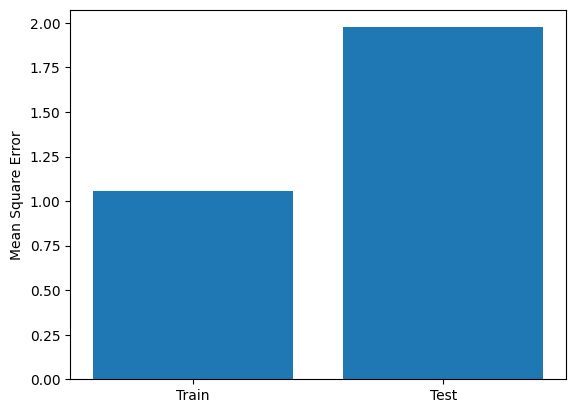

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cột thể hiện giá trị Mean Square Error trên tập huấn luyện và tập kiểm tra
x = ["Train", "Test"]
y = [train_mse, test_mse]

plt.bar(x, y)
plt.ylabel("Mean Square Error")
plt.show()